# Data Preparation

## Loading Data

Preparing DataFrame object with markers expression and corresponding cell labels.

In [1]:
import anndata
import pandas as pd
import numpy as np


TRAIN_ANNDATA_PATH = "train/cell_data.h5ad"

In [2]:
train_anndata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)
labels = list(train_anndata.obs.iloc[:, -1])

In [3]:
labels = list(train_anndata.obs.iloc[:, -1])
markers_names = list(train_anndata.var["marker"])

In [4]:
exprs_matrix = train_anndata.layers["exprs"]

In [5]:
# Creating expression DataFrame
df = pd.DataFrame(exprs_matrix)
df.columns = markers_names

# Adding labels column
df["label"] = labels

In [6]:
df.head()

,MPO,HistoneH3,SMA,CD16,CD38,HLADR,CD27,CD15,CD45RA,CD163,...,CD40,CD4,CD14,Ecad,CD303,CD206,cleavedPARP,DNA1,DNA2,label
0,0.000000,1.819988,0.502650,1.265410,0.515007,3.331261,0.403800,0.455421,0.528734,2.948392,...,0.567238,1.651610,2.556218,0.777378,0.000000,3.581082,0.424273,4.761130,5.301351,MacCD163
1,0.135920,2.393087,1.136961,0.505529,0.605836,0.710857,0.419814,0.100110,0.743002,0.329851,...,0.603468,1.358368,1.700181,1.884778,0.068872,0.744634,0.118620,5.029241,5.530764,Mural
2,0.165905,2.244917,1.396334,1.744382,0.458541,4.006500,0.003607,0.562882,1.236516,1.747839,...,0.812795,1.949510,3.465199,1.743507,0.403610,2.244398,0.015141,4.418390,4.815923,DC
3,0.165905,1.144778,0.563216,1.166010,0.513735,2.034705,0.650242,0.250150,1.205007,0.990385,...,1.228290,2.287524,2.491710,2.268924,0.196199,0.946492,0.233095,3.736089,4.368012,Tumor
4,0.137497,2.210970,0.892371,0.497646,0.412840,1.499184,0.098131,0.208566,0.922874,1.255892,...,0.360098,1.445085,2.332546,2.387292,0.061568,1.632904,0.372278,4.607359,5.152041,Tumor


## Splitting Data

Splitting data into test set and training set. Then training set I split further to cross validation folds.

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[markers_names], 
                                                    df["label"], 
                                                    random_state=12, 
                                                    stratify=df["label"],
                                                    shuffle=True,
                                                    train_size=0.85
                                                   )

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

In [10]:
folds = skf.split(X_train, y_train)

## Random Forest Classifier

Firstly I performed GridSearch for the optimal parameters:

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [12]:
parameters = {'n_estimators':[300, 500],
              "max_depth":[15, 17, None],
              "criterion":['gini'], 
              'max_features':['sqrt'], 
              "min_samples_split":[10]}

In [13]:
tree_grid = RandomForestClassifier(random_state=12)

In [14]:
grid_search = GridSearchCV(tree_grid, 
                           param_grid=parameters, 
                           cv=folds, 
                           scoring='accuracy', 
                           refit=True,
                           verbose = 4, 
                           n_jobs = -1)
grid_res = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500;, score=0.960 total time=31.1min
[CV 2/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500;, score=0.961 total time=31.1min
[CV 3/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500;, score=0.960 total time=31.2min
[CV 4/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500;, score=0.958 total time=31.4min
[CV 5/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500;, score=0.958 total time=31.5min


**Best overall cross-validational Accuracy was nearly 96%**

In [15]:
grid_res.best_score_

0.9593634391308399

In [16]:
grid_res.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 500}

### Model evaluation on the test set

In [17]:
# Packages
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import pickle

In [18]:
best_model=grid_res.best_estimator_

In [19]:
with open("best_RF.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [20]:
with open("best_RF.pkl", "rb") as f:
    best_model = pickle.load(f)

#### Global metrics (`ACC`, `macro-F1`):

In [21]:
y_pred = best_model.predict(X_test)

In [22]:
ACC = accuracy_score(y_test, y_pred, normalize=True)

In [23]:
macro_F1 = f1_score(y_test, y_pred, average='macro')

In [24]:
print(f"ACC on the test set: {ACC}")
print(f"macro_F1 on the test set: {macro_F1}")

ACC on the test set: 0.9588107773304428
macro_F1 on the test set: 0.9135231273403984


#### Confusion matrix:

In [25]:
cell_types = df['label'].unique()
cell_types.sort() 

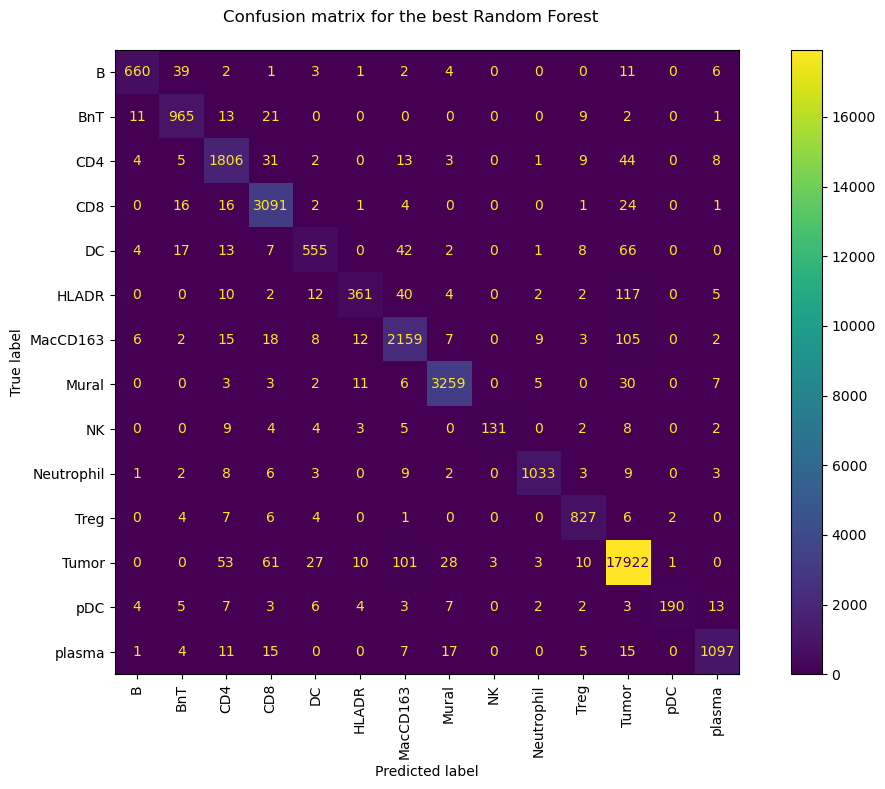

In [26]:
disp = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, xticks_rotation='vertical', display_labels=cell_types)
fig = disp.figure_
fig.set_figwidth(11)
fig.set_figheight(8) 
fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.suptitle('Confusion matrix for the best Random Forest')

confusion_matrix = disp.confusion_matrix
ACC_per_celltype = confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)

#### AUC, Average Precision Score (AP) and ACC across cell types

In [27]:
# Predict probabilities
y_prob = best_model.predict_proba(X_test)

In [28]:
AUC_per_celltype = roc_auc_score(y_test, y_prob, average=None, multi_class='ovr', labels=cell_types)

In [29]:
AP_per_celltype = average_precision_score(y_test, y_prob, average=None)

In [32]:
res = np.concatenate((AUC_per_celltype.reshape(-1, 1), AP_per_celltype.reshape(-1, 1), ACC_per_celltype.reshape(-1, 1)), axis=1)
res_df = pd.DataFrame(res, columns=["AUC","AP","ACC"], index=cell_types)

In [33]:
res_df

,AUC,AP,ACC
B,0.999695,0.986830,0.905350
BnT,0.999550,0.986363,0.944227
CD4,0.998421,0.978588,0.937695
CD8,0.999373,0.993838,0.979404
DC,0.996993,0.922800,0.776224
HLADR,0.994198,0.845166,0.650450
MacCD163,0.997930,0.972166,0.920290
Mural,0.999767,0.997750,0.979856
NK,0.999786,0.959278,0.779762
Neutrophil,0.999874,0.996250,0.957368


#### Sklearn report:

In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=cell_types))

              precision    recall  f1-score   support

           B       0.96      0.91      0.93       729
         BnT       0.91      0.94      0.93      1022
         CD4       0.92      0.94      0.93      1926
         CD8       0.95      0.98      0.96      3156
          DC       0.88      0.78      0.83       715
       HLADR       0.90      0.65      0.75       555
    MacCD163       0.90      0.92      0.91      2346
       Mural       0.98      0.98      0.98      3326
          NK       0.98      0.78      0.87       168
  Neutrophil       0.98      0.96      0.97      1079
        Treg       0.94      0.96      0.95       857
       Tumor       0.98      0.98      0.98     18219
         pDC       0.98      0.76      0.86       249
      plasma       0.96      0.94      0.95      1172

    accuracy                           0.96     35519
   macro avg       0.94      0.89      0.91     35519
weighted avg       0.96      0.96      0.96     35519

